In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib
pathlib.Path.ls = lambda x: list(x.iterdir())

In [3]:
import os
from datetime import datetime

import numpy as np
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [4]:
from evaluate import evaluate
from onsets_and_frames import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

leave_one_out=None
batch_size = 8
sequence_length = 327680
model_complexity = 48

if torch.cuda.is_available() and torch.cuda.get_device_properties(torch.cuda.current_device()).total_memory < 10e9:
    batch_size //= 2
    sequence_length //= 2
    print(f'Reducing batch size to {batch_size} and sequence_length to {sequence_length} to save memory')

train_groups, validation_groups = ['train'], ['validation']

if leave_one_out is not None:
    all_years = {'2004', '2006', '2008', '2009', '2011', '2013', '2014', '2015', '2017'}
    train_groups = list(all_years - {str(leave_one_out)})
    validation_groups = [str(leave_one_out)]
    

In [6]:
dataset = MAESTRO(groups=train_groups, sequence_length=sequence_length)
dataset.purplearrow_process(groups=train_groups, id=0)

Loading group train:   0%|          | 0/954 [00:00<?, ?it/s]

Loading 1 group of MAESTRO at data/MAESTRO
purplearrow force reload


Loading group train:   0%|          | 1/954 [00:34<9:10:28, 34.66s/it]

purplearrow force reload


Loading group train:   1%|          | 9/954 [02:00<7:13:03, 27.50s/it]

purplearrow force reload


Loading group train:   2%|▏         | 17/954 [02:39<5:23:26, 20.71s/it]

purplearrow force reload


Loading group train:   3%|▎         | 25/954 [04:14<4:39:12, 18.03s/it]

purplearrow force reload


Loading group train:   3%|▎         | 33/954 [06:59<4:48:39, 18.81s/it]

purplearrow force reload


Loading group train:   4%|▍         | 41/954 [07:56<3:53:02, 15.32s/it]

purplearrow force reload


Loading group train:   5%|▌         | 50/954 [10:56<3:04:59, 12.28s/it]

purplearrow force reload


Loading group train:   6%|▌         | 57/954 [14:05<4:09:22, 16.68s/it]

purplearrow force reload


Loading group train:   7%|▋         | 65/954 [17:25<4:44:05, 19.17s/it]

purplearrow force reload


Loading group train:   8%|▊         | 73/954 [18:31<3:53:33, 15.91s/it]

purplearrow force reload


Loading group train:   8%|▊         | 81/954 [20:25<3:44:13, 15.41s/it]

purplearrow force reload


Loading group train:   9%|▉         | 89/954 [22:41<3:49:00, 15.88s/it]

purplearrow force reload


Loading group train:  10%|█         | 97/954 [23:27<3:03:31, 12.85s/it]

purplearrow force reload


Loading group train:  11%|█         | 105/954 [25:30<3:12:13, 13.59s/it]

purplearrow force reload


Loading group train:  12%|█▏        | 113/954 [34:37<7:01:08, 30.05s/it]

purplearrow force reload


Loading group train:  13%|█▎        | 121/954 [36:40<5:55:49, 25.63s/it]

purplearrow force reload


Loading group train:  14%|█▎        | 129/954 [39:07<5:22:39, 23.47s/it]

purplearrow force reload


Loading group train:  14%|█▍        | 137/954 [46:26<7:27:41, 32.88s/it]

purplearrow force reload


Loading group train:  15%|█▌        | 145/954 [47:33<5:44:22, 25.54s/it]

purplearrow force reload


Loading group train:  16%|█▌        | 153/954 [51:36<6:00:24, 27.00s/it]

purplearrow force reload


Loading group train:  17%|█▋        | 161/954 [52:30<4:36:24, 20.91s/it]

purplearrow force reload


Loading group train:  18%|█▊        | 169/954 [54:36<4:13:09, 19.35s/it]

purplearrow force reload


Loading group train:  19%|█▊        | 177/954 [57:00<4:05:34, 18.96s/it]

purplearrow force reload


Loading group train:  19%|█▉        | 185/954 [1:03:39<6:02:03, 28.25s/it]

purplearrow force reload


Loading group train:  20%|██        | 193/954 [1:05:35<5:05:45, 24.11s/it]

purplearrow force reload


Loading group train:  21%|██        | 201/954 [1:08:28<4:53:03, 23.35s/it]

purplearrow force reload


Loading group train:  22%|██▏       | 209/954 [1:10:24<4:17:05, 20.71s/it]

purplearrow force reload


Loading group train:  23%|██▎       | 217/954 [1:12:54<4:06:54, 20.10s/it]

purplearrow force reload


Loading group train:  24%|██▎       | 225/954 [1:14:12<3:26:51, 17.03s/it]

purplearrow force reload


Loading group train:  24%|██▍       | 233/954 [1:15:20<2:53:45, 14.46s/it]

purplearrow force reload


Loading group train:  25%|██▌       | 241/954 [1:16:12<2:23:18, 12.06s/it]

purplearrow force reload


Loading group train:  26%|██▌       | 249/954 [1:16:54<1:57:54, 10.03s/it]

purplearrow force reload


Loading group train:  27%|██▋       | 257/954 [1:18:55<2:14:09, 11.55s/it]

purplearrow force reload


Loading group train:  28%|██▊       | 265/954 [1:19:40<1:52:09,  9.77s/it]

purplearrow force reload


Loading group train:  29%|██▊       | 273/954 [1:21:47<2:11:36, 11.60s/it]

purplearrow force reload


Loading group train:  29%|██▉       | 281/954 [1:25:06<2:54:59, 15.60s/it]

purplearrow force reload


Loading group train:  30%|███       | 289/954 [1:28:06<3:15:32, 17.64s/it]

purplearrow force reload


Loading group train:  31%|███       | 297/954 [1:28:57<2:36:34, 14.30s/it]

purplearrow force reload


Loading group train:  32%|███▏      | 305/954 [1:30:57<2:36:47, 14.50s/it]

purplearrow force reload


Loading group train:  33%|███▎      | 313/954 [1:32:55<2:35:28, 14.55s/it]

purplearrow force reload


Loading group train:  34%|███▎      | 321/954 [1:39:49<4:31:26, 25.73s/it]

purplearrow force reload


Loading group train:  34%|███▍      | 329/954 [1:47:32<6:08:23, 35.37s/it]

purplearrow force reload


Loading group train:  35%|███▌      | 337/954 [1:49:30<5:00:11, 29.19s/it]

purplearrow force reload


Loading group train:  36%|███▌      | 345/954 [1:51:11<4:05:51, 24.22s/it]

purplearrow force reload


Loading group train:  37%|███▋      | 353/954 [1:52:19<3:15:09, 19.48s/it]

purplearrow force reload


Loading group train:  38%|███▊      | 361/954 [1:57:50<4:17:32, 26.06s/it]

purplearrow force reload


Loading group train:  39%|███▊      | 369/954 [2:00:00<3:45:33, 23.13s/it]

purplearrow force reload


Loading group train:  40%|███▉      | 377/954 [2:05:46<4:40:21, 29.15s/it]

purplearrow force reload


Loading group train:  40%|████      | 385/954 [2:07:01<3:40:17, 23.23s/it]

purplearrow force reload


Loading group train:  41%|████      | 393/954 [2:09:07<3:16:00, 20.96s/it]

purplearrow force reload


Loading group train:  42%|████▏     | 401/954 [2:10:03<2:34:54, 16.81s/it]

purplearrow force reload


Loading group train:  43%|████▎     | 409/954 [2:12:41<2:40:27, 17.67s/it]

purplearrow force reload


Loading group train:  44%|████▎     | 417/954 [2:13:24<2:05:04, 13.97s/it]

purplearrow force reload


Loading group train:  45%|████▍     | 425/954 [2:15:39<2:11:07, 14.87s/it]

purplearrow force reload


Loading group train:  45%|████▌     | 433/954 [2:16:38<1:49:23, 12.60s/it]

purplearrow force reload


Loading group train:  46%|████▌     | 441/954 [2:17:28<1:31:31, 10.70s/it]

purplearrow force reload


Loading group train:  47%|████▋     | 449/954 [2:17:56<1:11:52,  8.54s/it]

purplearrow force reload


Loading group train:  48%|████▊     | 457/954 [2:18:30<1:00:05,  7.25s/it]

purplearrow force reload


Loading group train:  49%|████▊     | 465/954 [2:19:46<1:04:42,  7.94s/it]

purplearrow force reload


Loading group train:  50%|████▉     | 473/954 [2:20:54<1:04:53,  8.09s/it]

purplearrow force reload


Loading group train:  50%|█████     | 481/954 [2:21:28<54:43,  6.94s/it]  

purplearrow force reload


Loading group train:  51%|█████▏    | 489/954 [2:23:32<1:13:39,  9.50s/it]

purplearrow force reload


Loading group train:  52%|█████▏    | 497/954 [2:24:23<1:05:21,  8.58s/it]

purplearrow force reload


Loading group train:  53%|█████▎    | 505/954 [2:26:09<1:14:41,  9.98s/it]

purplearrow force reload


Loading group train:  54%|█████▍    | 513/954 [2:27:00<1:05:17,  8.88s/it]

purplearrow force reload


Loading group train:  55%|█████▍    | 521/954 [2:28:10<1:03:52,  8.85s/it]

purplearrow force reload


Loading group train:  55%|█████▌    | 529/954 [2:28:20<46:34,  6.58s/it]  

purplearrow force reload


Loading group train:  56%|█████▋    | 537/954 [2:29:25<48:46,  7.02s/it]

purplearrow force reload


Loading group train:  57%|█████▋    | 545/954 [2:30:48<54:46,  8.04s/it]

purplearrow force reload


Loading group train:  58%|█████▊    | 553/954 [2:34:08<1:27:51, 13.15s/it]

purplearrow force reload


Loading group train:  59%|█████▉    | 561/954 [2:35:26<1:19:18, 12.11s/it]

purplearrow force reload


Loading group train:  60%|█████▉    | 569/954 [2:36:26<1:08:56, 10.75s/it]

purplearrow force reload


Loading group train:  60%|██████    | 577/954 [2:37:40<1:04:32, 10.27s/it]

purplearrow force reload


Loading group train:  61%|██████▏   | 585/954 [2:40:18<1:20:43, 13.13s/it]

purplearrow force reload


Loading group train:  62%|██████▏   | 593/954 [2:42:14<1:21:34, 13.56s/it]

purplearrow force reload


Loading group train:  63%|██████▎   | 601/954 [2:43:21<1:10:36, 12.00s/it]

purplearrow force reload


Loading group train:  64%|██████▍   | 609/954 [2:43:49<54:17,  9.44s/it]  

purplearrow force reload


Loading group train:  65%|██████▍   | 617/954 [2:44:24<44:26,  7.91s/it]

purplearrow force reload


Loading group train:  66%|██████▌   | 625/954 [2:46:19<53:58,  9.84s/it]

purplearrow force reload


Loading group train:  66%|██████▋   | 633/954 [2:48:13<59:44, 11.17s/it]

purplearrow force reload


Loading group train:  67%|██████▋   | 641/954 [2:50:17<1:05:01, 12.46s/it]

purplearrow force reload


Loading group train:  68%|██████▊   | 649/954 [2:51:23<56:53, 11.19s/it]  

purplearrow force reload


Loading group train:  69%|██████▉   | 657/954 [2:53:15<59:36, 12.04s/it]

purplearrow force reload


Loading group train:  70%|██████▉   | 665/954 [2:55:45<1:07:49, 14.08s/it]

purplearrow force reload


Loading group train:  71%|███████   | 673/954 [2:59:00<1:20:20, 17.15s/it]

purplearrow force reload


Loading group train:  71%|███████▏  | 681/954 [3:08:22<2:30:32, 33.09s/it]

purplearrow force reload


Loading group train:  72%|███████▏  | 689/954 [3:10:51<2:06:55, 28.74s/it]

purplearrow force reload


Loading group train:  73%|███████▎  | 697/954 [3:11:43<1:34:34, 22.08s/it]

purplearrow force reload


Loading group train:  74%|███████▍  | 705/954 [3:13:58<1:25:03, 20.49s/it]

purplearrow force reload


Loading group train:  75%|███████▍  | 713/954 [3:19:13<1:45:07, 26.17s/it]

purplearrow force reload


Loading group train:  76%|███████▌  | 721/954 [3:26:52<2:18:03, 35.55s/it]

purplearrow force reload


Loading group train:  76%|███████▋  | 729/954 [3:29:50<1:58:20, 31.56s/it]

purplearrow force reload


Loading group train:  77%|███████▋  | 737/954 [3:30:53<1:28:22, 24.44s/it]

purplearrow force reload


Loading group train:  78%|███████▊  | 745/954 [3:33:08<1:17:16, 22.19s/it]

purplearrow force reload


Loading group train:  79%|███████▉  | 753/954 [3:36:53<1:20:12, 23.94s/it]

purplearrow force reload


Loading group train:  80%|███████▉  | 761/954 [3:39:16<1:11:11, 22.13s/it]

purplearrow force reload


Loading group train:  81%|████████  | 769/954 [3:40:43<57:50, 18.76s/it]  

purplearrow force reload


Loading group train:  81%|████████▏ | 777/954 [3:44:11<1:01:44, 20.93s/it]

purplearrow force reload


Loading group train:  82%|████████▏ | 785/954 [3:45:33<49:56, 17.73s/it]  

purplearrow force reload


Loading group train:  83%|████████▎ | 793/954 [3:46:30<39:03, 14.55s/it]

purplearrow force reload


Loading group train:  84%|████████▍ | 801/954 [3:47:02<29:02, 11.39s/it]

purplearrow force reload


Loading group train:  85%|████████▍ | 809/954 [3:48:34<27:31, 11.39s/it]

purplearrow force reload


Loading group train:  86%|████████▌ | 817/954 [3:50:34<28:33, 12.50s/it]

purplearrow force reload


Loading group train:  86%|████████▋ | 825/954 [3:53:42<33:59, 15.81s/it]

purplearrow force reload


Loading group train:  87%|████████▋ | 833/954 [3:57:55<41:26, 20.55s/it]

purplearrow force reload


Loading group train:  88%|████████▊ | 841/954 [4:00:54<39:42, 21.08s/it]

purplearrow force reload


Loading group train:  89%|████████▉ | 849/954 [4:02:25<31:46, 18.16s/it]

purplearrow force reload


Loading group train:  90%|████████▉ | 857/954 [4:04:14<27:09, 16.80s/it]

purplearrow force reload


Loading group train:  91%|█████████ | 865/954 [4:05:07<20:25, 13.77s/it]

purplearrow force reload


Loading group train:  92%|█████████▏| 873/954 [4:06:34<17:23, 12.88s/it]

purplearrow force reload


Loading group train:  92%|█████████▏| 881/954 [4:08:36<16:33, 13.61s/it]

purplearrow force reload


Loading group train:  93%|█████████▎| 889/954 [4:09:31<12:32, 11.58s/it]

purplearrow force reload


Loading group train:  94%|█████████▍| 897/954 [4:11:42<12:23, 13.04s/it]

purplearrow force reload


Loading group train:  95%|█████████▍| 905/954 [4:12:16<08:28, 10.37s/it]

purplearrow force reload


Loading group train:  96%|█████████▌| 913/954 [4:12:55<05:58,  8.75s/it]

purplearrow force reload


Loading group train:  97%|█████████▋| 921/954 [4:14:05<04:47,  8.72s/it]

purplearrow force reload


Loading group train:  97%|█████████▋| 929/954 [4:16:40<04:58, 11.92s/it]

purplearrow force reload


Loading group train:  98%|█████████▊| 937/954 [4:18:07<03:17, 11.62s/it]

purplearrow force reload


Loading group train:  99%|█████████▉| 945/954 [4:19:54<01:49, 12.14s/it]

purplearrow force reload


Loading group train: 100%|██████████| 954/954 [4:22:08<00:00, 16.49s/it]


In [49]:
import soundfile

In [61]:
audio, sr = soundfile.read('data/MAESTRO/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.flac', dtype='int16')

In [62]:
print (sr, SAMPLE_RATE, audio.max(), audio.min())
print (type(audio), audio.dtype)

16000 16000 26387 -25298
<class 'numpy.ndarray'> int16


In [60]:
#librosa load
y, sr = librosa.load(librosa.util.example_audio_file())
print (type(y),y.dtype, sr, y.max(), y.min())

<class 'numpy.ndarray'> float32 22050 0.6505927 -0.7105112


In [55]:
import librosa

In [65]:
faudio = np.float32(audio)
print (audio.dtype, audio.max(), audio.min())
print (faudio.dtype, faudio.max(), faudio.min())

int16 26387 -25298
float32 26387.0 -25298.0


In [96]:
def gen_shift_audio(audio, sr):
    faudio = np.float32(audio)
    shift_audios = []
    shifts = []
    for i in range(-4, 5):
        if i == 0: continue
        result = librosa.effects.pitch_shift(faudio, sr, n_steps=i)
        result = np.int16(result)
        shift_audios.append(result)
        shifts.append(i)
    return shift_audios, shifts


In [97]:
shift_audios, shifts = gen_shift_audio(audio, sr)

In [101]:
print (shifts)
print (shift_audios[0].shape, shift_audios[0].dtype)
print (audio.shape, audio.dtype)

[-4, -3, -2, -1, 1, 2, 3, 4]
(4279018,) int16
(4279018,) int16


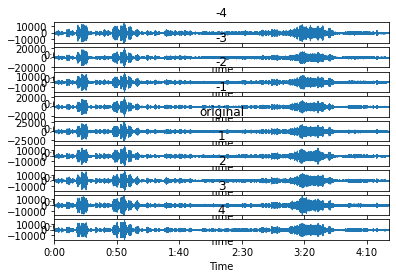

In [86]:
plt.figure()
for i in range(-4,5):
    if i == 0: 
        plt.subplot(9, 1, i+5)
        librosa.display.waveplot(faudio, sr=sr)
        plt.title('original')
    else:
        result = librosa.effects.pitch_shift(faudio, sr, n_steps=i)
        plt.subplot(9, 1, i+5)
        librosa.display.waveplot(result, sr=sr)
        plt.title(i)
    
    #result = np.int16(result)
    #print (i, result.dtype, result.max(), result.min())

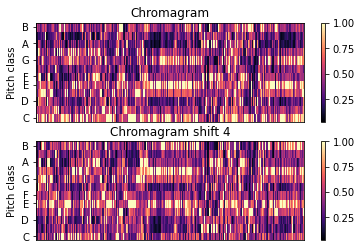

In [94]:
C = librosa.feature.chroma_cqt(y=faudio, sr=sr)
plt.subplot(2, 1, 1)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

result = librosa.effects.pitch_shift(faudio, sr, n_steps=4)
C = librosa.feature.chroma_cqt(y=result, sr=sr)
plt.subplot(2, 1, 2)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram shift 4')
plt.show()


In [78]:
import matplotlib.pyplot as plt
import librosa.display

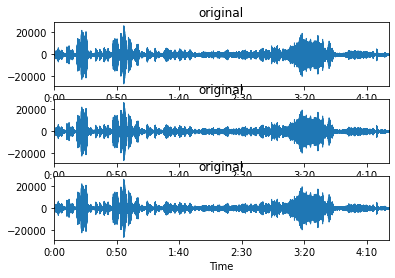

In [84]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(faudio, sr=sr)
plt.title('original')
plt.subplot(3, 1, 2)
librosa.display.waveplot(faudio, sr=sr)
plt.title('original')
plt.subplot(3, 1, 3)
librosa.display.waveplot(faudio, sr=sr)
plt.title('original')
plt.show()